# About

This dataset contains images of rice paddies with and without diseases.

kaggle dataset: https://www.kaggle.com/competitions/paddy-disease-classification/overview

A training dataset of 10,407 (75%) labeled images across ten classes (nine disease categories and normal leaf).

Your task is to classify each paddy image in the given test dataset of 3,469 (25%) images into one of the nine disease categories or a normal leaf.

Ref: https://www.youtube.com/watch?v=cagqUrHMDJ0&list=PLfYUBJiXbdtSLBPJ1GMx-sQWf6iNhb8mM&index=7

---

In [1]:
from fastai.vision.all import *


In [2]:
Path.BASE_PATH = Path.home()/".fastai/data/paddy-disease-classification"
path = Path.home()/".fastai/data/paddy-disease-classification"

In [3]:
path

Path('.')

In [4]:
path.ls()

(#4) [Path('train.csv'),Path('test_images'),Path('sample_submission.csv'),Path('train_images')]

In [5]:
# Create a dataframe by reading the CSV
df = pd.read_csv(path/"train.csv")
type(df)

pandas.core.frame.DataFrame

In [6]:
df

image_id                  label variety  age
0      100330.jpg  bacterial_leaf_blight   ADT45   45
1      100365.jpg  bacterial_leaf_blight   ADT45   45
2      100382.jpg  bacterial_leaf_blight   ADT45   45
3      100632.jpg  bacterial_leaf_blight   ADT45   45
4      101918.jpg  bacterial_leaf_blight   ADT45   45
...           ...                    ...     ...  ...
10402  107607.jpg                 tungro   Zonal   55
10403  107811.jpg                 tungro   Zonal   55
10404  108547.jpg                 tungro   Zonal   55
10405  110245.jpg                 tungro   Zonal   55
10406  110381.jpg                 tungro   Zonal   55

[10407 rows x 4 columns]

In [7]:
train_path = path/"train_images"

In [8]:
train_path.ls()

(#10) [Path('train_images/normal'),Path('train_images/brown_spot'),Path('train_images/hispa'),Path('train_images/bacterial_leaf_blight'),Path('train_images/tungro'),Path('train_images/blast'),Path('train_images/downy_mildew'),Path('train_images/dead_heart'),Path('train_images/bacterial_leaf_streak'),Path('train_images/bacterial_panicle_blight')]

In [9]:
bacterial_leaf_blight = train_path/"bacterial_leaf_blight"

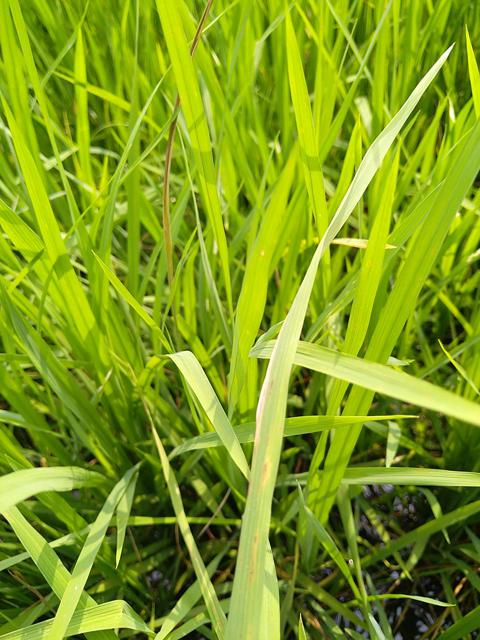

In [10]:
# Look into the first image in the training set
img = PILImage.create(bacterial_leaf_blight/"100330.jpg")
img

In [11]:
img.size

(480, 640)

In [12]:
# Another way to look into the image files
files = get_image_files(train_path/"bacterial_leaf_blight")

In [13]:
files[0]

Path('train_images/bacterial_leaf_blight/109304.jpg')

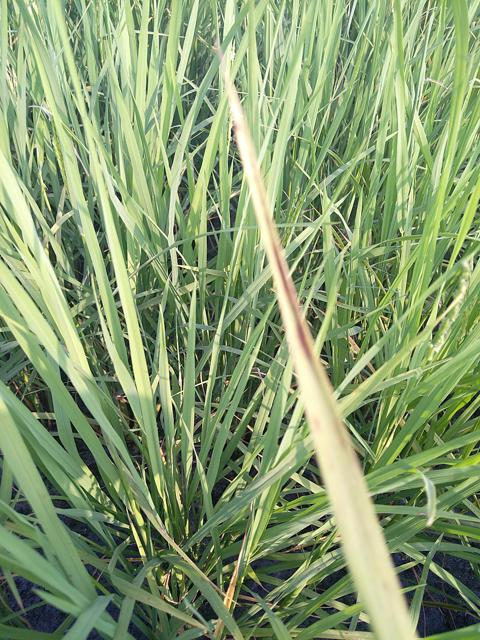

In [14]:
PILImage.create(files[0])

In [15]:
# Check image size is consistent
%time [PILImage.create(f).size for f in files][:10]

CPU times: user 692 ms, sys: 20.9 ms, total: 713 ms
Wall time: 809 ms


[(480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640),
 (480, 640)]

In [16]:
# We can also check the sizes in parallel - which is a lot faster because of threading?
from fastcore.parallel import *

In [17]:
doc(parallel)

In [18]:
def ret_image_size(f): return PILImage.create(f).size

In [19]:
%time parallel(ret_image_size, files, n_workers=3)

CPU times: user 83 ms, sys: 80.2 ms, total: 163 ms
Wall time: 671 ms


(#479) [(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640),(480, 640)...]

In [20]:
# List the grain varieties
df.variety.value_counts()

variety
ADT45             6992
KarnatakaPonni     988
Ponni              657
AtchayaPonni       461
Zonal              399
AndraPonni         377
Onthanel           351
IR20               114
RR                  36
Surya               32
Name: count, dtype: int64

In [21]:
path.ls()

(#4) [Path('train.csv'),Path('test_images'),Path('sample_submission.csv'),Path('train_images')]

In [22]:
# Create dataloaders - note how we're directly using the image dataloaders instead of creating a Datablock
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, item_tfms=Resize(224))

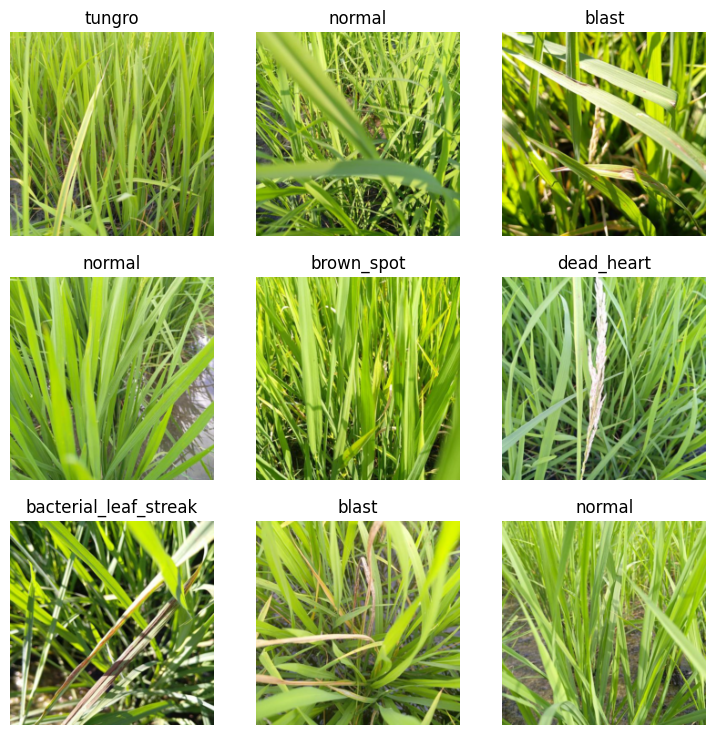

In [23]:
dls.show_batch()

In [24]:
# Create dataloaders - by using Datablock
paddies = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

In [25]:
doc(DataBlock)

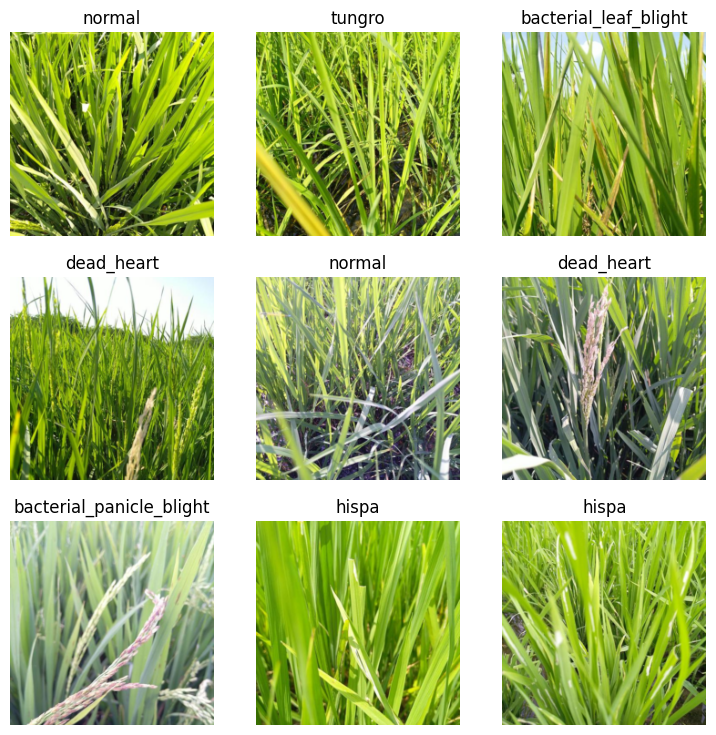

In [26]:
dls = paddies.dataloaders(train_path)
dls.show_batch()

Choose a model for transfer learning
https://www.kaggle.com/code/jhoward/which-image-models-are-best

In [27]:
import timm

In [28]:
# List the models we can use for transfer learning
timm.list_models("convnext_small*", pretrained=True)

['convnext_small.fb_in1k',
 'convnext_small.fb_in22k',
 'convnext_small.fb_in22k_ft_in1k',
 'convnext_small.fb_in22k_ft_in1k_384',
 'convnext_small.in12k',
 'convnext_small.in12k_ft_in1k',
 'convnext_small.in12k_ft_in1k_384']

In [29]:
learn = vision_learner(dls, "convnext_small.fb_in22k", metrics=error_rate).to_fp16()

In [30]:
doc(learn.fine_tune)

In [31]:
# This function changes the precision of the floating numbers to 16bit precission
# This will make things faster compared to running the learner on full precission floating points.
doc(learn.to_fp16)

In [32]:
learn.fine_tune(2)

Minimum/10:	4.79e-07
Steepest point:	1.32e-06
Longest valley:	1.91e-06
Slide interval:	4.37e-05


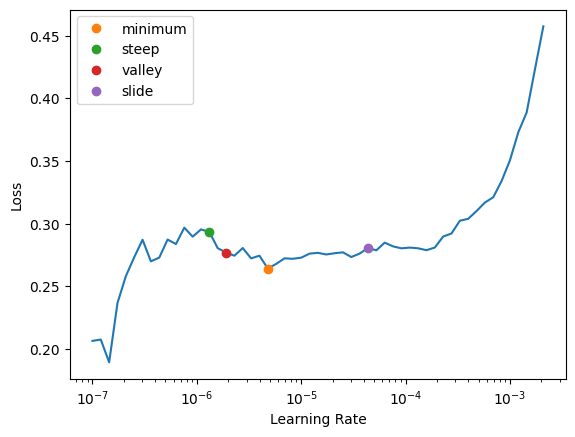

In [35]:
# Find the learning rate - empirically fastai picks a good lr 0.02
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
# Shows how lr compares to Loss.
print(f"Minimum/10:\t{lr_min:.2e}\nSteepest point:\t{lr_steep:.2e}\nLongest valley:\t{lr_valley:.2e}\nSlide interval:\t{lr_slide:.2e}")

You need to pick a `LR` which actually trains the model and improves its `Loss`.

In [34]:
doc(Learner.lr_find)

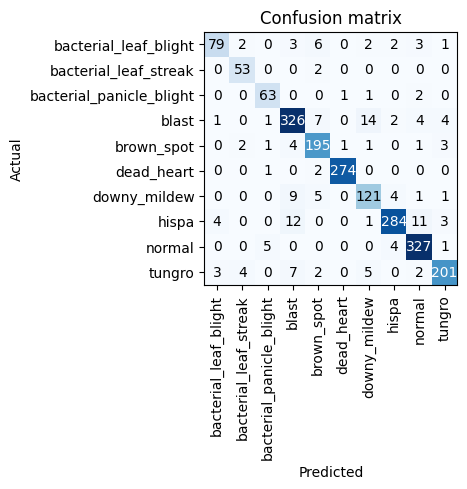

In [43]:
# Plot the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [39]:
# Let's test the model
doc(dls.test_dl)

In [70]:
test_files = get_image_files(path/"test_images").sorted()

In [71]:
test_files

(#3469) [Path('test_images/200001.jpg'),Path('test_images/200002.jpg'),Path('test_images/200003.jpg'),Path('test_images/200004.jpg'),Path('test_images/200005.jpg'),Path('test_images/200006.jpg'),Path('test_images/200007.jpg'),Path('test_images/200008.jpg'),Path('test_images/200009.jpg'),Path('test_images/200010.jpg')...]

In [72]:
test_dl = dls.test_dl(test_files)

In [73]:
# By default the predictions are the probabilities of each class.
learn.get_preds(dl=test_dl)

(tensor([[9.8039e-03, 1.3409e-04, 2.5546e-04,  ..., 9.6265e-01, 2.2108e-04,
          3.6988e-04],
         [2.5925e-05, 2.9039e-04, 3.6525e-05,  ..., 1.9929e-04, 9.9928e-01,
          1.0922e-04],
         [8.8080e-03, 3.7164e-03, 3.0840e-03,  ..., 1.5951e-02, 1.8284e-02,
          5.3365e-03],
         ...,
         [2.3886e-03, 4.9450e-04, 1.0093e-04,  ..., 6.6330e-04, 9.9520e-01,
          5.9902e-04],
         [3.0140e-03, 3.8636e-01, 1.1736e-02,  ..., 2.2824e-01, 2.7514e-02,
          4.7417e-02],
         [1.0383e-10, 3.2044e-10, 1.4168e-08,  ..., 1.0608e-10, 7.9387e-10,
          1.7986e-09]]),
 None)

In [74]:
predictions = learn.get_preds(dl=test_dl, with_decoded=True)

In [75]:
probs, _, idxs = predictions

In [76]:
# This has the indexes of the labels for each image in the test dataset
idxs

tensor([7, 8, 6,  ..., 8, 1, 5])

In [77]:
dls.vocab

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']

We need to turn the `idxs` into the labesl in the `vocab`.

In [78]:
dls.vocab[idxs]

(#3469) ['hispa','normal','downy_mildew','blast','blast','brown_spot','dead_heart','brown_spot','hispa','normal'...]

In [79]:
# How the submission looks like
sample_submission = pd.read_csv(path/"sample_submission.csv")
sample_submission

image_id  label
0     200001.jpg    NaN
1     200002.jpg    NaN
2     200003.jpg    NaN
3     200004.jpg    NaN
4     200005.jpg    NaN
...          ...    ...
3464  203465.jpg    NaN
3465  203466.jpg    NaN
3466  203467.jpg    NaN
3467  203468.jpg    NaN
3468  203469.jpg    NaN

[3469 rows x 2 columns]

In [80]:
# Construct the submission
sample_submission["label"] = dls.vocab[idxs]

In [81]:
sample_submission.head(n=30)

image_id                  label
0   200001.jpg                  hispa
1   200002.jpg                 normal
2   200003.jpg           downy_mildew
3   200004.jpg                  blast
4   200005.jpg                  blast
5   200006.jpg             brown_spot
6   200007.jpg             dead_heart
7   200008.jpg             brown_spot
8   200009.jpg                  hispa
9   200010.jpg                 normal
10  200011.jpg             dead_heart
11  200012.jpg                  hispa
12  200013.jpg                 normal
13  200014.jpg             dead_heart
14  200015.jpg                 normal
15  200016.jpg                  blast
16  200017.jpg                 tungro
17  200018.jpg                  hispa
18  200019.jpg             dead_heart
19  200020.jpg             dead_heart
20  200021.jpg                 normal
21  200022.jpg                 tungro
22  200023.jpg  bacterial_leaf_blight
23  200024.jpg             dead_heart
24  200025.jpg                  blast
25  200026.jpg                  hispa
26  200027.jpg                  blast
27  200028.jpg             brown_spot
28  200029.jpg             dead_heart
29  200030.jpg  bacterial_leaf_blight

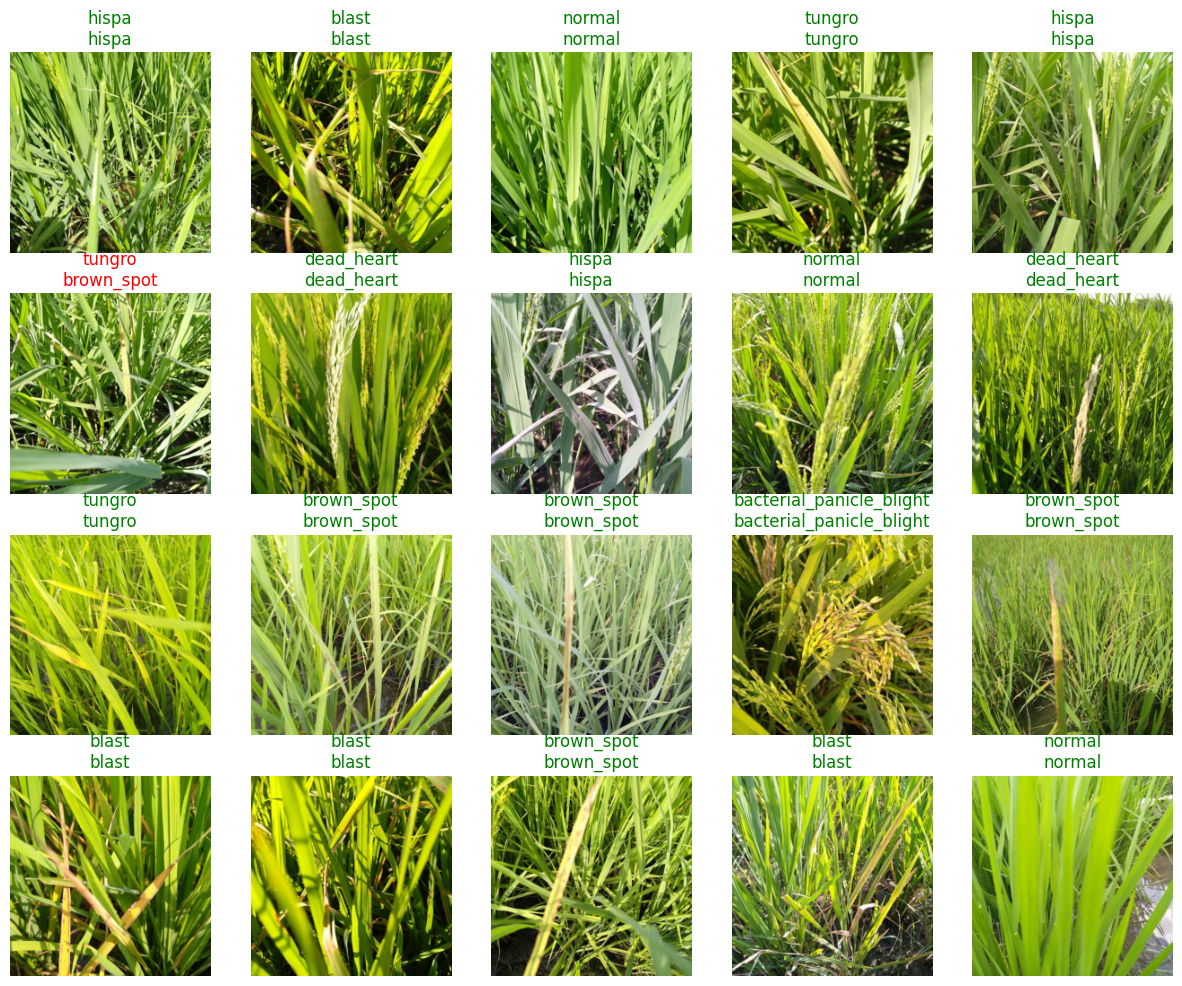

In [82]:
# Easiest way to show some results
learn.show_results(max_n=20)

In [83]:
sample_submission.to_csv("my_predictions.csv", index=False)

In [84]:
!head my_predictions.csv

image_id,label
200001.jpg,hispa
200002.jpg,normal
200003.jpg,downy_mildew
200004.jpg,blast
200005.jpg,blast
200006.jpg,brown_spot
200007.jpg,dead_heart
200008.jpg,brown_spot
200009.jpg,hispa
